In [1]:
import os
import pandas as pd
import json
import seaborn as sns
from typing import List

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)


# Base directory setup
notebook_dir = os.path.abspath("")
base_experiment_dir = os.path.join(
    notebook_dir, "..", "results", "experiments", ExperimentFolders.GPT_41
)


# Function to load all experiment files into DataFrames
def load_experiment_data(files: List[ExperimentFiles], base_dir: str) -> pd.DataFrame:
    dfs = []
    for file in files:
        path = os.path.join(base_dir, file)
        try:
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            df["experiment_name"] = file  # Add column to identify the experiment
            dfs.append(df)
        except Exception as e:
            print(f"Failed to load {file}: {e}")
    return pd.concat(dfs, ignore_index=True)


# Load all experiments
all_files = list(ExperimentFiles)
df = load_experiment_data(all_files, base_experiment_dir)

# Now you can compare/filter by experiment_name
print(df["experiment_name"].value_counts())

experiment_name
triage_local.json                              91
all_tools_local.json                           91
all_tools_local_no_ranking.json                91
triage_mcp.json                                91
triage_mcp_seq_websearch.json                  91
all_tools_mcp_websearch.json                   91
all_tools_mcp_seq.json                         91
all_tools_mcp_seq_websearch.json               91
all_tools_mcp_seq_websearch_no_ranking.json    91
Name: count, dtype: int64


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         819 non-null    object 
 1   question                                   819 non-null    object 
 2   answer                                     819 non-null    object 
 3   product                                    819 non-null    object 
 4   category                                   819 non-null    object 
 5   persona                                    819 non-null    object 
 6   activity                                   819 non-null    object 
 7   country                                    819 non-null    object 
 8   facts                                      819 non-null    object 
 9   bert_score                                 819 non-null    float64
 10  agent_judge_outcome       

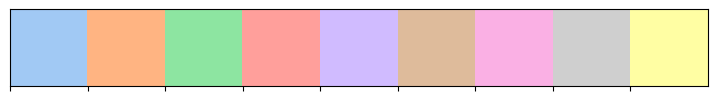

In [3]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

# Data Preparation

In [4]:
# Strip .json and map to CONF codes
name_map = {
    "all_tools_local_no_ranking": "CONF-1",
    "all_tools_local": "CONF-2",
    "all_tools_mcp_seq": "CONF-3",
    "all_tools_mcp_websearch": "CONF-4",
    "all_tools_mcp_seq_websearch_no_ranking": "CONF-5",
    "all_tools_mcp_seq_websearch": "CONF-6",
    "triage_local": "CONF-7",
    "triage_mcp": "CONF-8",
    "triage_mcp_seq_websearch": "CONF-9",
}

# Strip .json, map to CONF code
df["experiment_name"] = df["experiment_name"].str.replace(".json", "", regex=False)
df["experiment_name"] = df["experiment_name"].map(name_map)

# Optional: verify if any names failed to map (e.g. got NaN)
unmapped = df["experiment_name"].isna().sum()
if unmapped > 0:
    print(f"Warning: {unmapped} rows have unmapped experiment names.")

# Sort by experiment_name (CONF-X)
df = df.sort_values(
    by="experiment_name", key=lambda col: col.str.extract(r"CONF-(\d+)")[0].astype(int)
)

# Direct Fact Score

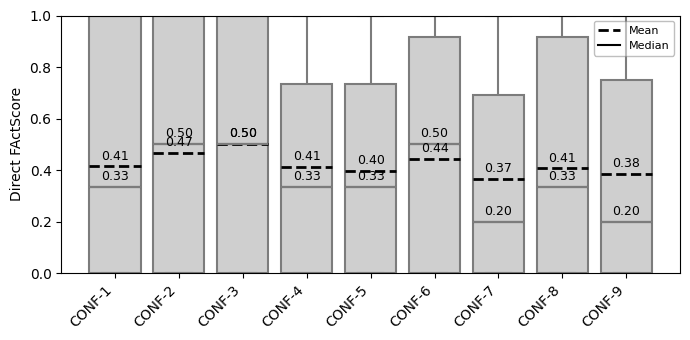

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(7, 3.5))

# Draw boxplot and save the axis object
ax = sns.boxplot(
    data=df,
    x="experiment_name",
    y="fact_score.direct_fact_score",
    color=my_palette[7],
    showfliers=False,
    linewidth=1.5,
)

# Get the x-tick positions (center of each box)
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute statistics
means = df.groupby("experiment_name")["fact_score.direct_fact_score"].mean()
medians = df.groupby("experiment_name")["fact_score.direct_fact_score"].median()

# Map experiment names to positions
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay mean and median lines with annotations
for i, (experiment, pos) in enumerate(pos_map.items()):
    mean_val = means.get(experiment)
    median_val = medians.get(experiment)

    if mean_val is not None:
        plt.hlines(
            mean_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="--",
            linewidth=2,
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

    if median_val is not None:
        plt.hlines(
            median_val,
            pos - 0.40,
            pos + 0.40,
            colors="black",
            linestyles="-",
            linewidth=1.5,
        )
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

# Final formatting
plt.xlabel("")
plt.ylabel("Direct FActScore")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# Inline legend inside top-right of plot with transparent background
legend = ax.legend(
    handles=[
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=2, label="Mean"),
        plt.Line2D(
            [0], [0], color="black", linestyle="-", linewidth=1.5, label="Median"
        ),
    ],
    loc="upper right",
    fontsize=8,
    frameon=True,
)

# Customize legend box appearance
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.5)  # Slight transparency
legend.get_frame().set_edgecolor("gray")

plt.tight_layout()
plt.show()

# Agent as a judge outcome

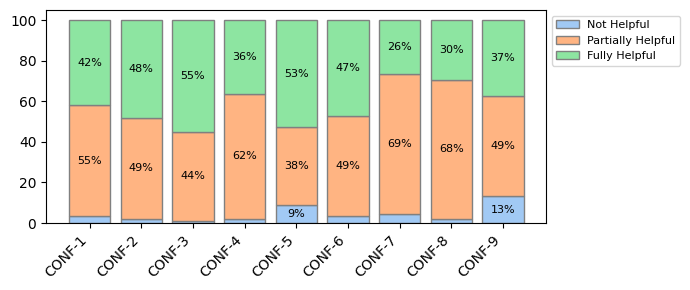

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group and count
stacked_data = (
    df.groupby(["experiment_name", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Desired outcome stacking order
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
stacked_data = stacked_data[desired_order]

# Sort experiment names like CONF-1, CONF-2, etc.
stacked_data = stacked_data.reindex(
    sorted(stacked_data.index, key=lambda x: int(x.split("-")[1]))
)

# Convert to percentages row-wise
stacked_percent = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# Plot
plt.figure(figsize=(7, 3))
bottom = [0] * len(stacked_percent)

for idx, outcome in enumerate(desired_order):
    values = stacked_percent[outcome].values
    bars = plt.bar(
        stacked_percent.index,
        values,
        bottom=bottom,
        label=outcome,
        color=my_palette[idx],
        edgecolor="gray",
    )

    # Annotate with percent labels (skip small segments)
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val >= 5:  # Only annotate if >= 5% to avoid clutter
            plt.text(
                i,
                btm + val / 2,
                f"{val:.0f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )

    bottom = [btm + val for btm, val in zip(bottom, values)]

# Labels and legend
plt.xticks(rotation=45, ha="right")
plt.legend(
    bbox_to_anchor=(1, 1),
    loc="upper left",
    fontsize=8,
)
plt.tight_layout()
plt.show()

# Token Consumption

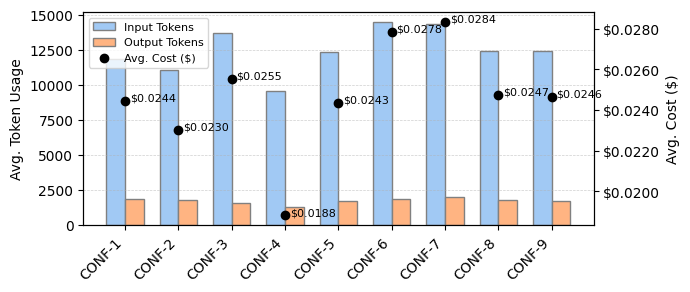

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
import seaborn as sns

# Custom colors (replace or define your palette)
my_palette = sns.color_palette("pastel")

# -- Preprocess --

# Token usage per experiment
token_cols = [
    "tokens_consumed.input_tokens",
    "tokens_consumed.output_tokens",
]
mean_token_usage = df.groupby("experiment_name")[token_cols].mean().reset_index()

# Cost per experiment
from experiments.interpretation.interpretation_util import ModelPricing

grouped = df.groupby("experiment_name")
agent_costs = {
    exp: (
        (group["tokens_consumed.input_tokens"].mean() / 1000)
        * ModelPricing[group["model_used"].iloc[0]]["input"]
        + (group["tokens_consumed.output_tokens"].mean() / 1000)
        * ModelPricing[group["model_used"].iloc[0]]["output"]
    )
    for exp, group in grouped
}

# -- Create figure --
fig, ax1 = plt.subplots(figsize=(7, 3))

x = mean_token_usage["experiment_name"]
input_tokens = mean_token_usage["tokens_consumed.input_tokens"]
output_tokens = mean_token_usage["tokens_consumed.output_tokens"]

bar_width = 0.35
x_pos = range(len(x))

bar1 = ax1.bar(
    [i - bar_width / 2 for i in x_pos],
    input_tokens,
    width=bar_width,
    color=my_palette[0],
    edgecolor="gray",
    label="Input Tokens",
)

bar2 = ax1.bar(
    [i + bar_width / 2 for i in x_pos],
    output_tokens,
    width=bar_width,
    color=my_palette[1],
    edgecolor="gray",
    label="Output Tokens",
)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(x, rotation=45, ha="right")
ax1.set_ylabel("Avg. Token Usage")
ax1.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Plot cost using secondary y-axis
ax2 = ax1.twinx()
costs = [agent_costs[exp] for exp in x]
line = ax2.scatter(
    x_pos,
    costs,
    color="black",
    marker="o",
    label="Avg. Cost ($)",
)

ax2.set_ylabel("Avg. Cost ($)")
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.4f}"))

# Annotate cost
for i, cost in enumerate(costs):
    ax2.annotate(
        f"${cost:.4f}",
        (i, cost),
        textcoords="offset points",
        xytext=(20, 0),
        ha="center",
        fontsize=8,
        color="black",
    )

# Combine legends
token_legend = [
    Patch(facecolor=my_palette[0], edgecolor="gray", label="Input Tokens"),
    Patch(facecolor=my_palette[1], edgecolor="gray", label="Output Tokens"),
]
all_handles = token_legend + [line]
ax1.legend(handles=all_handles, loc="upper left", fontsize=8, frameon=True)

plt.tight_layout()
plt.show()

# BERTScore

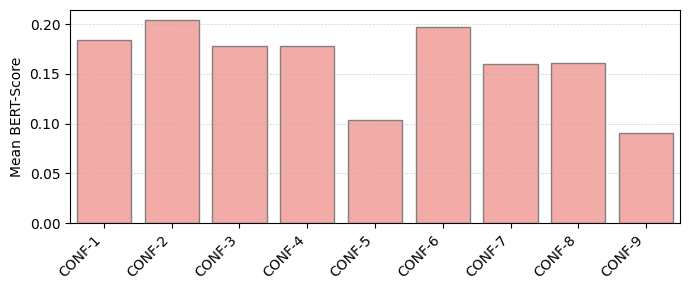

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["experiment_name"].unique()

# Compute mean BERT score per experiment
mean_bert = df.groupby("experiment_name")["bert_score"].mean().reset_index()

# Plot
plt.figure(figsize=(7, 3))
ax = sns.barplot(
    data=mean_bert,
    x="experiment_name",
    y="bert_score",
    order=experiment_order,
    color=my_palette[3],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Formatting
plt.xlabel("")
plt.ylabel("Mean BERT-Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Tool Calls

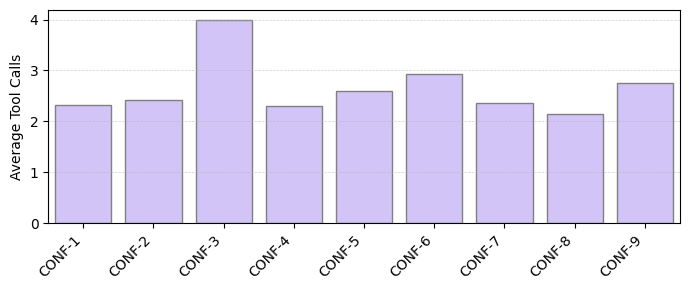

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df
experiment_order = df["experiment_name"].unique()

# Compute mean tool calls per experiment
mean_tools = df.groupby("experiment_name")["tool_calls_count"].mean().reset_index()

# Plot
plt.figure(figsize=(7, 3))
ax = sns.barplot(
    data=mean_tools,
    x="experiment_name",
    y="tool_calls_count",
    order=experiment_order,
    color=my_palette[4],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# Formatting
plt.xlabel("")
plt.ylabel("Average Tool Calls")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Time Consumed

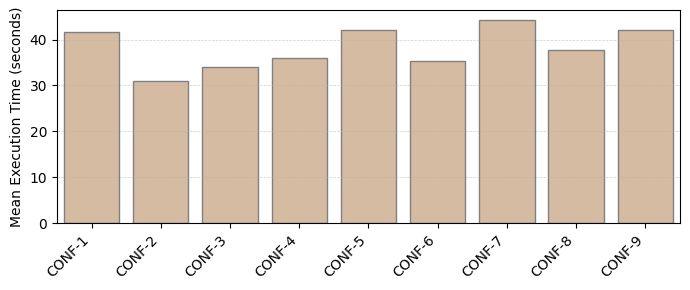

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume your DataFrame is named `df`

# Group by configuration (experiment_name), compute mean execution time
grouped = df.groupby("experiment_name")["excecution_time_seconds"].mean().reset_index()


# Plot
plt.figure(figsize=(7, 3))
sns.barplot(
    data=grouped,
    x="experiment_name",
    y="excecution_time_seconds",
    color=my_palette[5],
    edgecolor="gray",
)

# Grid for guidance
plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Execution Time (seconds)")
plt.xlabel("")
plt.tight_layout()
plt.show()